Deep Learning
=============

Assignment 2
------------

Previously in `1_notmnist.ipynb`, we created a pickle with formatted datasets for training, development and testing on the [notMNIST dataset](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

In [16]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
import seaborn as sbn

%matplotlib inline

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


### VERY IMPORTANT STEP
Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


We're first going to train a multinomial logistic regression using simple gradient descent.

TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...

Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [4]:
# Multinomial Logistic Regression using SIMPLE GD with TensorFlow
# Data(28x28) -> Wx+b=Y -> Softmax(Y) -> One-Hot Encoding (S(Y)) -> Apply Simple GD (Cross-Entropy Cost Function)

# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000 # as it's said, 200k samples of 28x28 each one it is prohibitive. Technical limitation.

graph = tf.Graph()
with graph.as_default():

  # Input data
  # Load the training, validation and test data into constants that are
  # attached to the graph 
  # MY COMMENT:(why aren't they placeholders?)
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
  tf_train_labels = tf.constant(train_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  # MY COMMENT: Check this out! initial conditions: w_i => random distribution; b_i => zeros
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run this computation and iterate:

In [10]:
num_steps = 801

plt_step = []
plt_train_acc = []
plt_val_acc = []

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 100 == 0):
      train_acc = accuracy(predictions, train_labels[:train_subset, :])
      val_acc = accuracy(valid_prediction.eval(), valid_labels)
      
      plt_step.append(step)
      plt_train_acc.append(train_acc)
      plt_val_acc.append(val_acc)
      
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % train_acc)
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % val_acc)
      print(' ')
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 18.955544
Training accuracy: 6.8%
Validation accuracy: 9.4%
 
Loss at step 100: 2.380575
Training accuracy: 71.3%
Validation accuracy: 69.8%
 
Loss at step 200: 1.900366
Training accuracy: 74.5%
Validation accuracy: 72.4%
 
Loss at step 300: 1.637146
Training accuracy: 75.7%
Validation accuracy: 73.3%
 
Loss at step 400: 1.459127
Training accuracy: 76.9%
Validation accuracy: 73.8%
 
Loss at step 500: 1.328958
Training accuracy: 77.6%
Validation accuracy: 74.1%
 
Loss at step 600: 1.228796
Training accuracy: 78.4%
Validation accuracy: 74.3%
 
Loss at step 700: 1.148743
Training accuracy: 78.8%
Validation accuracy: 74.5%
 
Loss at step 800: 1.082956
Training accuracy: 79.5%
Validation accuracy: 74.6%
 
Test accuracy: 82.8%


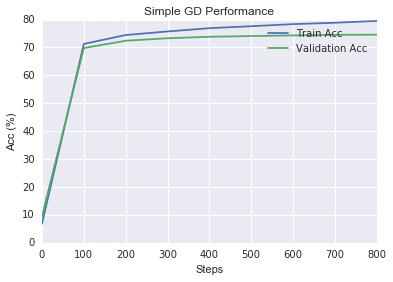

[0, 100, 200, 300, 400, 500, 600, 700, 800]
[6.78, 71.27, 74.45, 75.73, 76.91, 77.61, 78.36, 78.85, 79.51]
[9.43, 69.78, 72.4, 73.3, 73.83, 74.08, 74.32, 74.53, 74.57]


In [26]:
tr_line = plt.plot(plt_step, plt_train_acc, label='Train Acc')
val_line = plt.plot(plt_step, plt_val_acc, label='Validation Acc')
plt.xlabel('Steps')
plt.ylabel('Acc (%)')
plt.legend()
plt.title('Simple GD Performance')
plt.show()

print(plt_step)
print(plt_train_acc)
print(plt_val_acc)

Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `session.run()`.

In [24]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  # That's the main difference between "Simple" GD and SGD (placeholder and batch)
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run it:

In [27]:
num_steps = 3001 # Greater value! in theory this is going to be more efficient and it's going to have a 
# better performance. 

sgd_plt_step = []
sgd_plt_train_acc = []
sgd_plt_val_acc = []

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      train_acc = accuracy(predictions, batch_labels)
      val_acc = accuracy(valid_prediction.eval(), valid_labels)
      
      sgd_plt_step.append(step)
      sgd_plt_train_acc.append(train_acc)
      sgd_plt_val_acc.append(val_acc)
      
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % train_acc)
      print("Validation accuracy: %.1f%%" % val_acc)
      print(' ')
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 14.177502
Minibatch accuracy: 7.8%
Validation accuracy: 12.6%
 
Minibatch loss at step 500: 1.189812
Minibatch accuracy: 78.9%
Validation accuracy: 75.8%
 
Minibatch loss at step 1000: 1.528708
Minibatch accuracy: 71.9%
Validation accuracy: 76.4%
 
Minibatch loss at step 1500: 0.902703
Minibatch accuracy: 80.5%
Validation accuracy: 77.0%
 
Minibatch loss at step 2000: 0.907889
Minibatch accuracy: 81.2%
Validation accuracy: 77.1%
 
Minibatch loss at step 2500: 1.057021
Minibatch accuracy: 74.2%
Validation accuracy: 77.9%
 
Minibatch loss at step 3000: 0.846896
Minibatch accuracy: 79.7%
Validation accuracy: 78.5%
 
Test accuracy: 86.1%


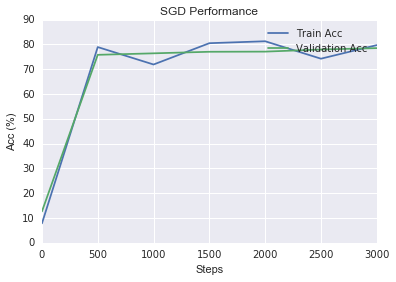

[0, 500, 1000, 1500, 2000, 2500, 3000]
[7.8125, 78.90625, 71.875, 80.46875, 81.25, 74.21875, 79.6875]
[12.64, 75.78, 76.38, 77.01, 77.07, 77.92, 78.48]


In [28]:
tr_line = plt.plot(sgd_plt_step, sgd_plt_train_acc, label='Train Acc')
val_line = plt.plot(sgd_plt_step, sgd_plt_val_acc, label='Validation Acc')
plt.xlabel('Steps')
plt.ylabel('Acc (%)')
plt.legend()
plt.title('SGD Performance')
plt.show()

print(sgd_plt_step)
print(sgd_plt_train_acc)
print(sgd_plt_val_acc)

---
Problem
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units [nn.relu()](https://www.tensorflow.org/versions/r0.7/api_docs/python/nn.html#relu) and 1024 hidden nodes. This model should improve your validation / test accuracy.

---

### 1-hidden layer neural network (2-layer neural network)

In [43]:
batch_size = 128
hidden_nodes = 1024 # H parameter. It will change weights_1,2 and biases_1,2 sizes!!

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  # That's the main difference between "Simple" GD and SGD (placeholder and batch)
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights_1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_nodes])) # Check this size out. 10 -> 1024
  biases_1 = tf.Variable(tf.zeros([hidden_nodes]))
  weights_2 = tf.Variable(
    tf.truncated_normal([hidden_nodes, num_labels])) # Check this size out.
  biases_2 = tf.Variable(tf.zeros([num_labels]))
  
  # Hidden Layer?? How to do it... let's check nn.relu() docu first :D
  # Training computation.
  def two_layer_nn(X):
    y_nn_1 = tf.matmul(X, weights_1) + biases_1
    y_hl = tf.nn.relu(y_nn_1)
    y = tf.matmul(y_hl, weights_2) + biases_2 # Y or logits
    return y

  logits = two_layer_nn(tf_train_dataset)

  loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(two_layer_nn(tf_valid_dataset))
  test_prediction = tf.nn.softmax(two_layer_nn(tf_test_dataset))

In [44]:
num_steps = 3001 # Greater value! in theory this is going to be more efficient and it's going to have a 
# better performance. 

oneh_plt_step = []
oneh_plt_train_acc = []
oneh_plt_val_acc = []

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      train_acc = accuracy(predictions, batch_labels)
      val_acc = accuracy(valid_prediction.eval(), valid_labels)
      
      oneh_plt_step.append(step)
      oneh_plt_train_acc.append(train_acc)
      oneh_plt_val_acc.append(val_acc)
      
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % train_acc)
      print("Validation accuracy: %.1f%%" % val_acc)
      print(' ')
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 577.533569
Minibatch accuracy: 7.8%
Validation accuracy: 29.6%
 
Minibatch loss at step 500: 40.418736
Minibatch accuracy: 82.8%
Validation accuracy: 79.2%
 
Minibatch loss at step 1000: 29.586437
Minibatch accuracy: 76.6%
Validation accuracy: 82.2%
 
Minibatch loss at step 1500: 8.435102
Minibatch accuracy: 91.4%
Validation accuracy: 83.1%
 
Minibatch loss at step 2000: 5.204154
Minibatch accuracy: 86.7%
Validation accuracy: 83.0%
 
Minibatch loss at step 2500: 7.544063
Minibatch accuracy: 86.7%
Validation accuracy: 83.6%
 
Minibatch loss at step 3000: 5.521748
Minibatch accuracy: 85.2%
Validation accuracy: 83.8%
 
Test accuracy: 90.6%


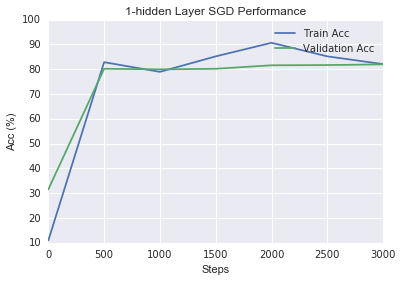

[0, 500, 1000, 1500, 2000, 2500, 3000]
[10.9375, 82.8125, 78.90625, 85.15625, 90.625, 85.15625, 82.03125]
[31.52, 80.16, 79.91, 80.15, 81.56, 81.65, 81.94]


In [42]:
tr_line = plt.plot(oneh_plt_step, oneh_plt_train_acc, label='Train Acc')
val_line = plt.plot(oneh_plt_step, oneh_plt_val_acc, label='Validation Acc')
plt.xlabel('Steps')
plt.ylabel('Acc (%)')
plt.legend()
plt.title('1-hidden Layer SGD Performance')
plt.show()

print(oneh_plt_step)
print(oneh_plt_train_acc)
print(oneh_plt_val_acc)